In [1]:
import os
import pandas as pd

allcards = pd.read_json('AllCards.json')

MedianCMC ToughnessToCMC


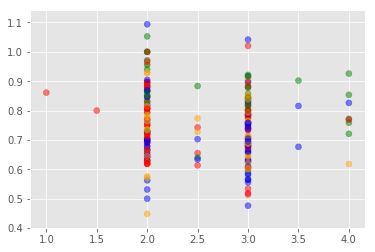

MedianCMC PowerToCMC


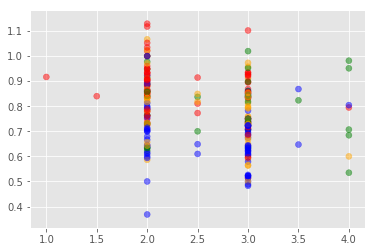

MedianCMC PowerToToughness


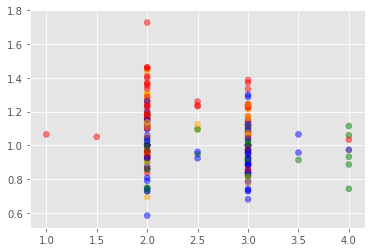

MedianCMC CreatureDensity


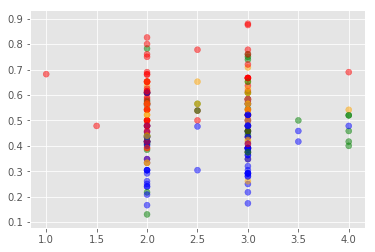

MedianCMC AverageCMCCreatures


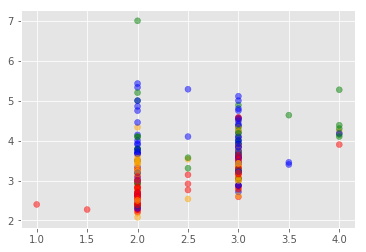

MedianCMC AverageToughness


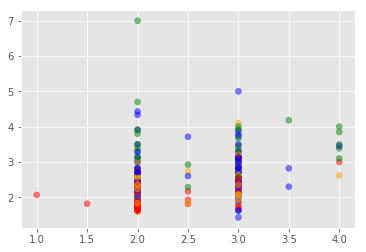

MedianCMC AveragePower


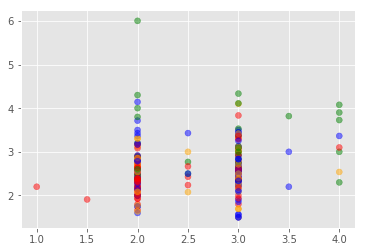

MedianCMC AverageCMC


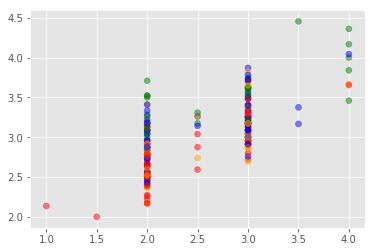

MedianCMC MaxCMC


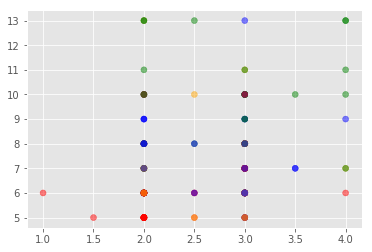

MedianCMC NumberOfCreatures


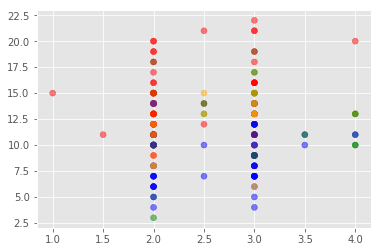

ToughnessToCMC PowerToCMC


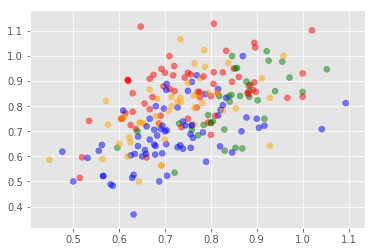

ToughnessToCMC PowerToToughness


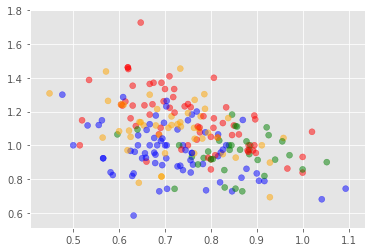

ToughnessToCMC CreatureDensity


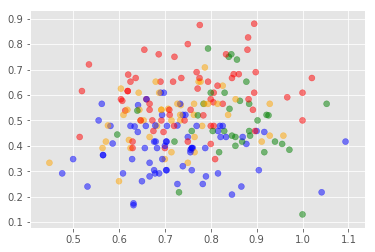

ToughnessToCMC AverageCMCCreatures


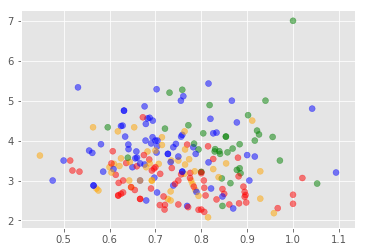

ToughnessToCMC AverageToughness


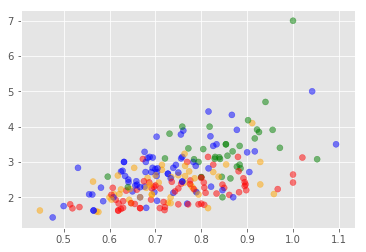

ToughnessToCMC AveragePower


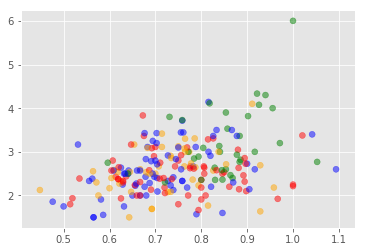

ToughnessToCMC AverageCMC


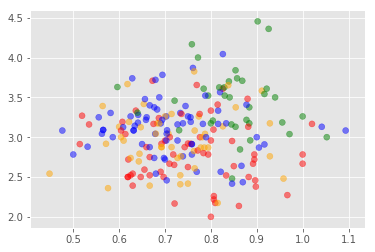

ToughnessToCMC MaxCMC


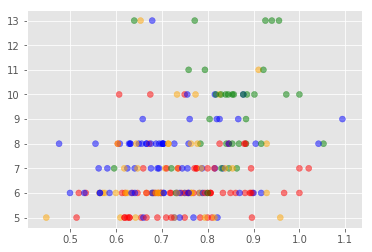

ToughnessToCMC NumberOfCreatures


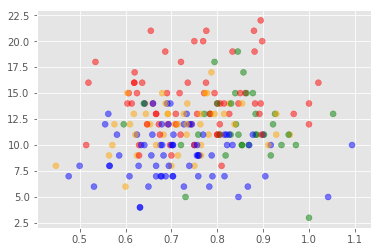

PowerToCMC PowerToToughness


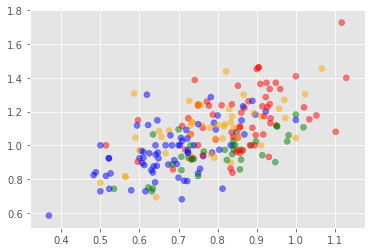

PowerToCMC CreatureDensity


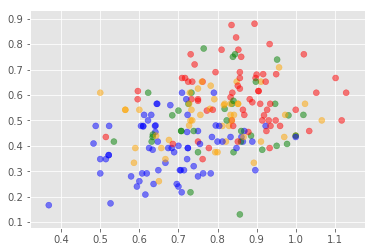

PowerToCMC AverageCMCCreatures


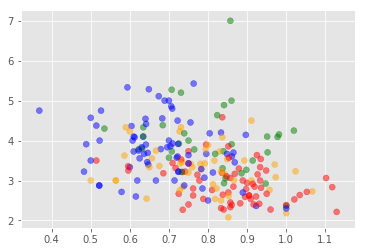

PowerToCMC AverageToughness


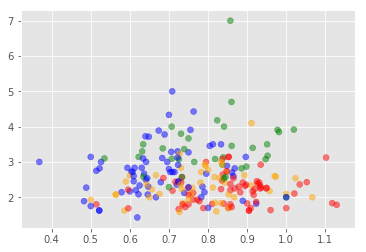

PowerToCMC AveragePower


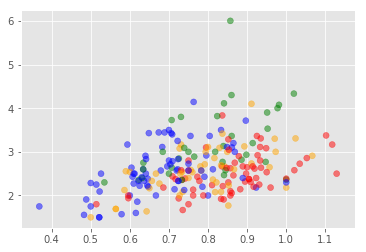

PowerToCMC AverageCMC


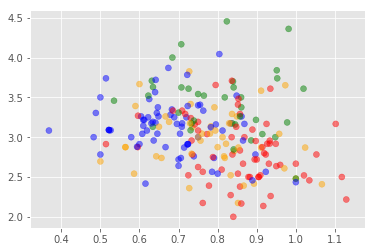

PowerToCMC MaxCMC


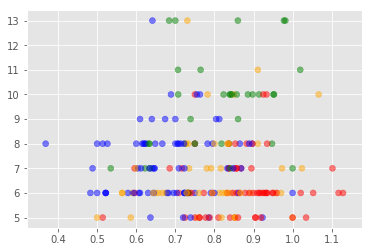

PowerToCMC NumberOfCreatures


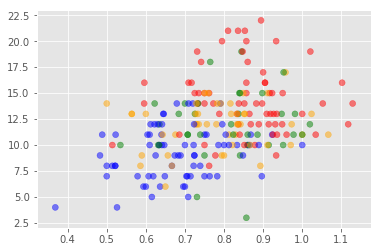

PowerToToughness CreatureDensity


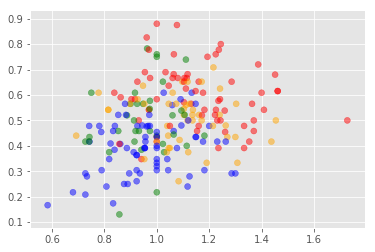

PowerToToughness AverageCMCCreatures


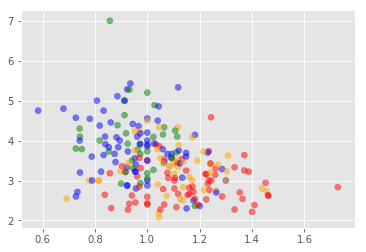

PowerToToughness AverageToughness


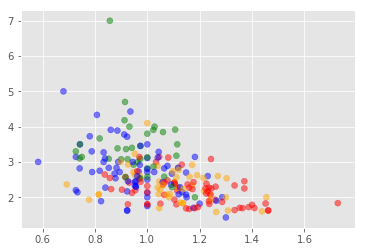

PowerToToughness AveragePower


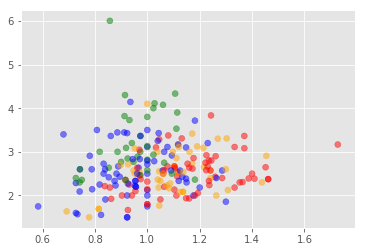

PowerToToughness AverageCMC


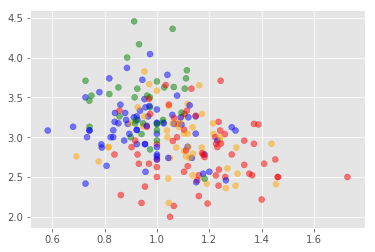

PowerToToughness MaxCMC


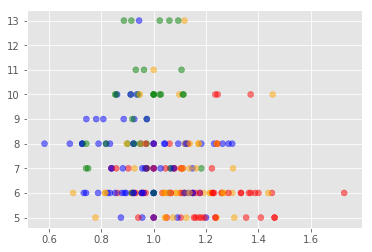

PowerToToughness NumberOfCreatures


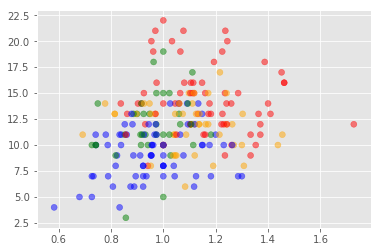

CreatureDensity AverageCMCCreatures


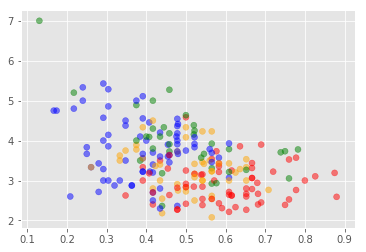

CreatureDensity AverageToughness


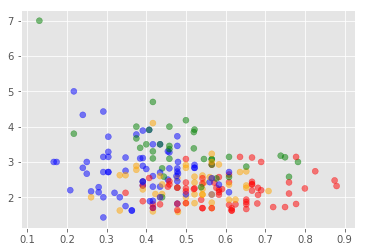

CreatureDensity AveragePower


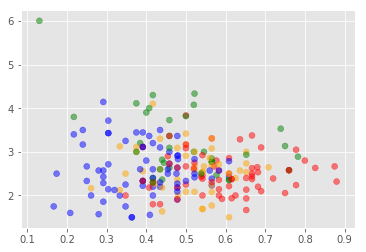

CreatureDensity AverageCMC


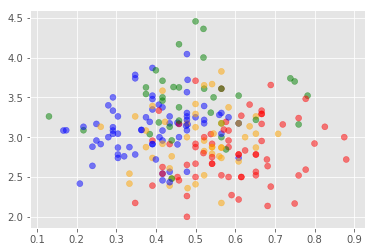

CreatureDensity MaxCMC


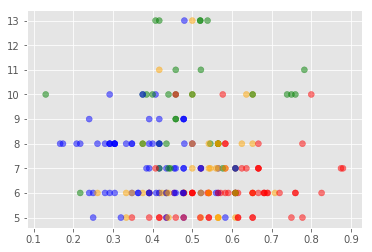

CreatureDensity NumberOfCreatures


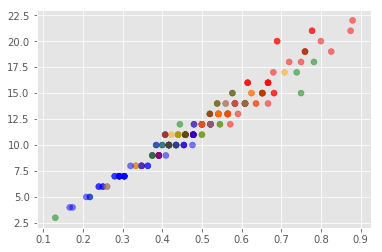

AverageCMCCreatures AverageToughness


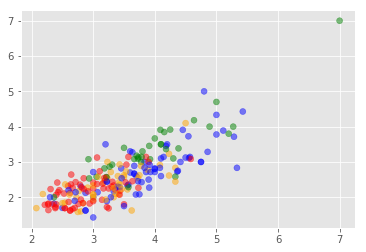

AverageCMCCreatures AveragePower


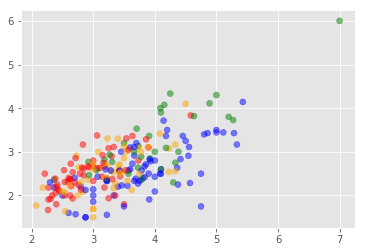

AverageCMCCreatures AverageCMC


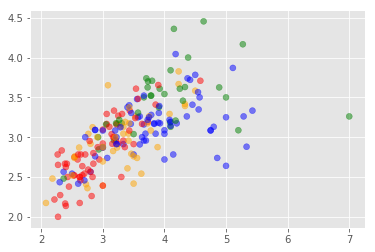

AverageCMCCreatures MaxCMC


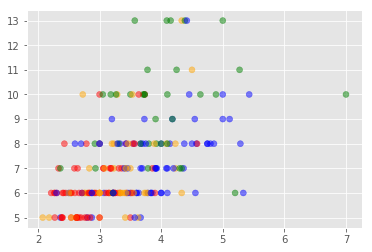

AverageCMCCreatures NumberOfCreatures


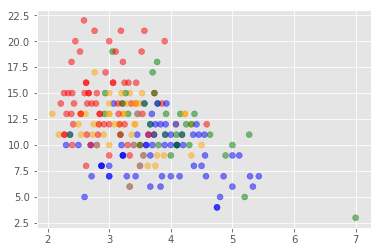

AverageToughness AveragePower


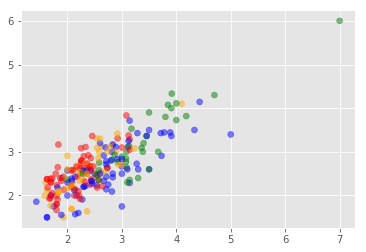

AverageToughness AverageCMC


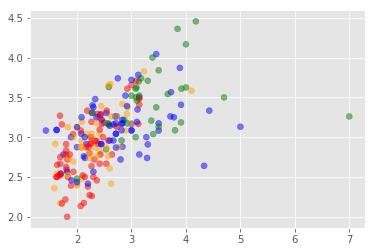

AverageToughness MaxCMC


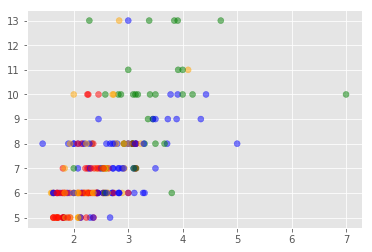

AverageToughness NumberOfCreatures


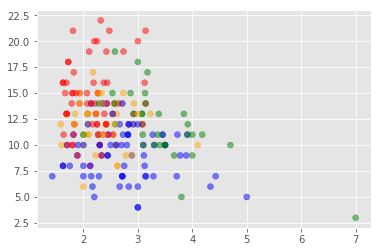

AveragePower AverageCMC


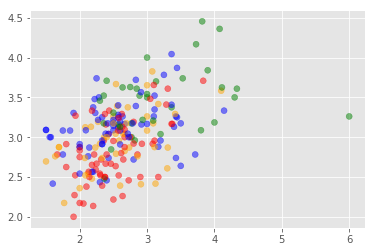

AveragePower MaxCMC


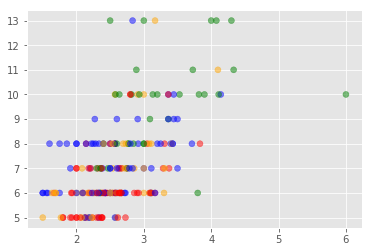

AveragePower NumberOfCreatures


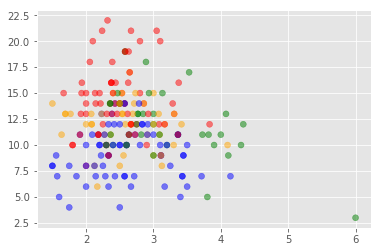

AverageCMC MaxCMC


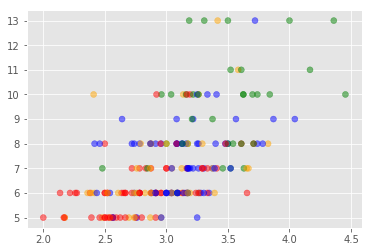

AverageCMC NumberOfCreatures


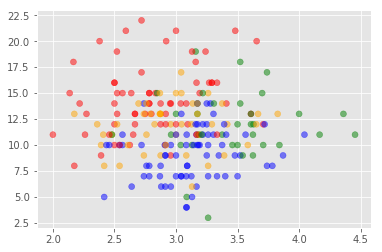

MaxCMC NumberOfCreatures


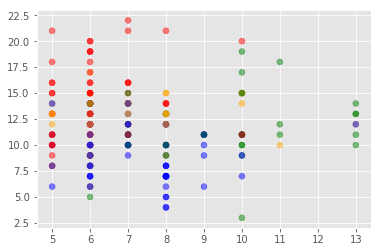

In [85]:
import numpy as np
import matplotlib.pyplot as plt

decklists_path = 'data/decks/'

class ArchetypeWorkshop():
        def __init__(self):
            self.deckfiles = []
            self.loadAllDeckFilenames()
            self.decks = []
            self.loadAllDecks()
            self.cards = []
            self.loadAllUsedCards()
            self.used_cards = []
            self.loadAllUsedCardsData()
            self.allcards =  allcards#[]
            #self.loadAllCardsData()
            self.deck_and_name=[]
            self.df = []
            
        def loadAllDeckFilenames(self):
            if len(self.deckfiles) == 0:
                tmp = os.listdir(decklists_path)
                deckfiles = []
                for i in tmp:
                    deckfiles.append(i.replace('~', ''))
                self.deckfiles = list(set(deckfiles))
                
        def loadDecks(self, filename):
            data = pd.read_json('data/decks/'+filename)
            return data['cards']
    
        def loadAllDecks(self):
            self.loadAllDeckFilenames()
            for i in self.deckfiles:
                tmp_decks = self.loadDecks(i)
                for d in tmp_decks:
                    self.decks.append(d)
    
        def loadAllUsedCards(self):
            if len(self.cards) == 0:
                self.loadAllDecks()
                for i in self.decks:
                    for j in i:
                        if "(ORI)" not in j:
                            self.cards.append(j)
                self.cards = sorted(list(set(self.cards)))
                
        def loadAllCardsData(self):
            if os.path.isfile('AllCards.json') == False:
                self.downloadAllCardsData()
            if len(self.allcards) == 0:
                self.allcards = pd.read_json('AllCards.json')
                
        def loadAllUsedCardsData(self):
            self.used_cards = pd.read_json('used_cards.json')
                
        def prepareAllUsedCardsData(self):
            used_cards = []
            for i in self.cards:
                used_cards.append(self.allcards[i])
            self.used_cards = used_cards
            
        def saveUsedCardsAsJson(self):
            df = pd.DataFrame(self.used_cards)
            df.to_json('used_cards.json')
            
            
        # actual archetype detection methods start here
        
        def loadDecksWithNames(self, filename):
            data = pd.read_json('data/decks/'+filename)
            return data['cards'], data['name']
        
        def loadAllDecksWithNames(self):
            self.loadAllDeckFilenames()
            for i in self.deckfiles:
                tmp_decks, tmp_names = self.loadDecksWithNames(i)
                for i in range(0, len(tmp_decks)):
                    self.deck_and_name.append((tmp_decks[i], tmp_names[i]))
                    
        def loadDeckWithAllInfo(self, filename):
            data = pd.read_json('data/decks/'+filename)
            return data['cards'], data['name'], data['player'], data['draft']
        
        def loadAllDecksWithAll(self):
            self.loadAllDeckFilenames()
            for i in self.deckfiles:
                tmp_decks, tmp_names, tmp_players, tmp_drafts = self.loadDeckWithAllInfo(i)
                for i in range(0, len(tmp_decks)):
                    self.deck_and_name.append([tmp_decks[i], tmp_names[i], tmp_players[i], tmp_drafts[i]])
                    
        def showCardTypes(self, deck):
            for i in deck:
                print self.allcards[i]['types']
                
        def getNonlandsOnly(self, deck):
            nonlands = []
            for i in deck:
                if 'Land' not in self.allcards[i]['types']:
                    nonlands.append(i)
            return nonlands
        
        def getNumberOfCardType(self, deck, cardtype):
            acc = 0
            for i in deck:
                if cardtype in self.allcards[i]['types']:
                    acc+=1
            return acc
        
        def getAverageCMC(self, deck):
            acc = 0
            for i in deck:
                acc+=self.allcards[i]['cmc']
                
            return round((acc+0.0)/len(deck), 4)
        
        def getAverageCMCForType(self, deck, cardtype):
            acc = 0
            counter = 0
            for i in deck:
                if cardtype in self.allcards[i]['types']:
                    acc+=self.allcards[i]['cmc']
                    counter+=1
            return round((acc+0.0)/counter, 4)
        
        def getMinMaxMedian(self, deck):
            cmcs = []
            for i in deck:
                cmcs.append(self.allcards[i]['cmc'])
                
            npcmcs = np.array(cmcs)
            return {
                'min': np.min(npcmcs),
                'max': np.max(npcmcs),
                'median': np.median(npcmcs)
            }
        
        def getAveragePowerToughness(self, deck):
            total_power = 0
            total_tough = 0
            total_cmc=0
            number = self.getNumberOfCardType(deck, 'Creature')
            for i in deck:
                if 'Creature' in self.allcards[i]['types']:
                    if self.allcards[i]['power'] not in ['X', '*']:
                        total_power += int(self.allcards[i]['power'])
                    if self.allcards[i]['toughness'] not in ['X', '*']:
                        total_tough += int(self.allcards[i]['toughness'])
                    total_cmc+=int(self.allcards[i]['cmc'])
            return {
                'ave_power': round((total_power+0.0)/number, 4),
                'ave_tough': round((total_tough+0.0)/number, 4),
                'total_power': total_power,
                'total_tough': total_tough,
                'power_cmc': round(total_power/(0.0+total_cmc), 4),
                'tough_cmc': round(total_tough/(0.0+total_cmc), 4)
            }
            
        def examineDeck(self, i):
            deck = self.deck_and_name[i][0]
            nonlands = self.getNonlandsOnly(deck)
            deck_name = self.deck_and_name[i][1]
            player_name = self.deck_and_name[i][2]
            draft_num = self.deck_and_name[i][3]
            tmp = deck_name.split(' ')
            simple_name = tmp[1]
            
            
            min_max_median = self.getMinMaxMedian(deck)
            average_power_toughness = self.getAveragePowerToughness(nonlands)
            creature_density = round(self.getNumberOfCardType(nonlands, 'Creature')/(0.0 + len(nonlands)), 4)
            power_to_toughness = round(average_power_toughness['total_power']/(0.0+average_power_toughness['total_tough']), 4)
                        
            return {
                'Name': simple_name,
                'NumberOfCreatures': self.getNumberOfCardType(nonlands, 'Creature'),
                #'NumberOfEquipments': self.getNumberOfCardSubtype(nonlands, 'Equipped'),
                'AverageCMC': self.getAverageCMC(nonlands),
                'AverageCMCCreatures': self.getAverageCMCForType(deck, 'Creature'),
                'CreatureDensity': creature_density,
                'PowerToToughness':power_to_toughness,
                'PowerToCMC': average_power_toughness['power_cmc'],
                'ToughnessToCMC': average_power_toughness['tough_cmc'],
                'MaxCMC': min_max_median['max'],
                'MedianCMC': min_max_median['median'],
                'AveragePower': average_power_toughness['ave_power'],
                'AverageToughness': average_power_toughness['ave_tough'],
                'Player and draft':player_name+'_'+draft_num
            }
        
        def examineAllDecks(self):
            self.results_all_decks = []
            for i in range(len(self.deck_and_name)):
                self.results_all_decks.append(self.examineDeck(i))
                
        def convertResultsToDataFrame(self):
            my_keys = self.results_all_decks[0].keys()
            self.pre_df = {}
            for i in my_keys:
                self.pre_df[i] = []
            
            for i in self.results_all_decks:
                for j in my_keys:
                    self.pre_df[j].append(i[j])
            
            self.df = pd.DataFrame.from_dict(self.pre_df)
            
        def showDistributionForEachParameter(self):
            my_keys = self.results_all_decks[0].keys()
            self.pre_df = {}
            for i in my_keys:
                self.pre_df[i] = []
            
            for i in self.results_all_decks:
                for j in my_keys:
                    self.pre_df[j].append(i[j])
                        
            for i in my_keys:
                if i not in ['Name', 'Player and draft']:
                    print i,'Max: ', max(self.pre_df[i]), 'Min: ', min(self.pre_df[i])
                    hist = self.df[i].hist(bins = 20)
                    plt.style.use('ggplot')
                    plt.show()
                    
        def getAllNumericalKeyPairs(self):
            my_keys = self.results_all_decks[0].keys()
            numeric_keys = []
            for i in my_keys:
                if i not in ['Name', 'Player and draft']:
                    numeric_keys.append(i)
                    
            pairs = []
            for i in range (0, len(numeric_keys)):
                for j in range (i+1, len(numeric_keys)):
                    pairs.append((numeric_keys[i], numeric_keys[j]))
                
            return pairs
        
        def getColorsByArchetypes(self):
            archetype_color_dict = {
                'Aggro': 'red',
                'Control': 'blue',
                'Mid-Range': 'orange',
                'Ramp': 'green',
                'aggro':'red'
            }
            colors = []
            for i in self.pre_df['Name']:
                colors.append(archetype_color_dict[i])
            
            return colors   
                    
        def showScatterPlotsForParameterPairs(self):
            key_pairs = self.getAllNumericalKeyPairs()
            colors = self.getColorsByArchetypes()
            
            for i in range(0, len(key_pairs)):          
                x_key = key_pairs[i][0]
                y_key = key_pairs[i][1]
            
                x = self.pre_df[x_key]
                y = self.pre_df[y_key]
          
                plt.scatter(x, y, c=colors, alpha=0.5)
                print x_key, y_key
                plt.show()
            
                #print self.pre_df[x_key], self.pre_df[y_key]
                    
                                
workshop = ArchetypeWorkshop()

workshop.loadAllDecksWithAll() # load all deck data

#workshop.loadAllCardsData() - not used due to issues with handling this data frame
#workshop.prepareAllUsedCardsData()  - not used due to issues with handling this data frame
#workshop.saveUsedCardsAsJson()  - not used due to issues with handling this data frame

workshop.examineAllDecks() # prepare parameters for each deck

workshop.convertResultsToDataFrame() # prepare data frame for further usage

#workshop.showDistributionForEachParameter() # show parameters distribution

workshop.showScatterPlotsForParameterPairs()

# prepare scatter plots with color depending on archetype for each parameteres pair



# normalize with using min and max values
# find most similar decks
# look at given names

# Normalize data from data frame

